In [1]:
%load_ext lab_black

In [2]:
import math
import os
import random
import shutil
import json
import logging
import sys
from collections import defaultdict
from datetime import datetime
from io import TextIOWrapper
from pathlib import Path
from typing import Callable, List, Sequence, Tuple

import albumentations as A
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from tqdm import tqdm
from PIL import Image

import utils
import networks

In [4]:
train_imgs = sorted(list(Path("data/box_effdet/train_imgs/").glob("*.jpg")))
keypoint_imgs = sorted(list(Path("data/box_effdet/train_keypoints/").glob("*.jpg")))

---

## 오류가 있는 이미지들 확인

최정명님 감사합니다 ^_^

In [5]:
error_list = [
    317,
    869,
    873,
    877,
    911,
    1559,
    1560,
    1562,
    1566,
    1575,
    1577,
    1578,
    1582,
    1606,
    1607,
    1622,
    1623,
    1624,
    1625,
    1629,
    3968,
    4115,
    4116,
    4117,
    4118,
    4119,
    4120,
    4121,
    4122,
    4123,
    4124,
    4125,
    4126,
    4127,
    4128,
    4129,
    4130,
    4131,
    4132,
    4133,
    4134,
    4135,
    4136,
    4137,
    4138,
    4139,
    4140,
    4141,
    4142,
    4143,
    4144,
    4145,
    4146,
    4147,
    4148,
    4149,
    4150,
    4151,
    4152,
    4153,
    4154,
    4155,
    4156,
    4157,
    4158,
    4159,
    4160,
    4161,
    4162,
    4163,
    4164,
    4165,
    4166,
    4167,
    4168,
    4169,
    4170,
    4171,
    4172,
    4173,
    4174,
    4175,
    4176,
    4177,
    4178,
    4179,
    4180,
    4181,
    4182,
    4183,
    4184,
    4185,
    4186,
    4187,
    4188,
    4189,
    4190,
    4191,
    4192,
    4193,
    4194,
]

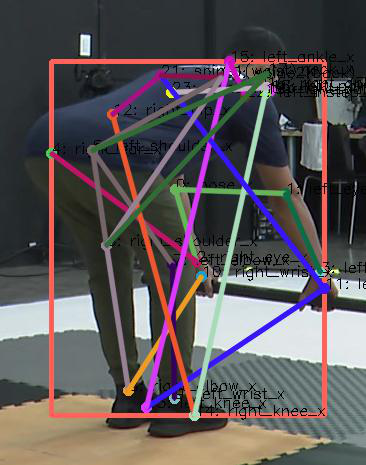

In [14]:
Image.fromarray(imageio.imread(keypoint_imgs[error_list[7]]))

---

## 이미지 비율 맞추기

가로로 긴거는 가로축을 기준으로 맞춰줄 것

세로 이미지의 대표적인 예

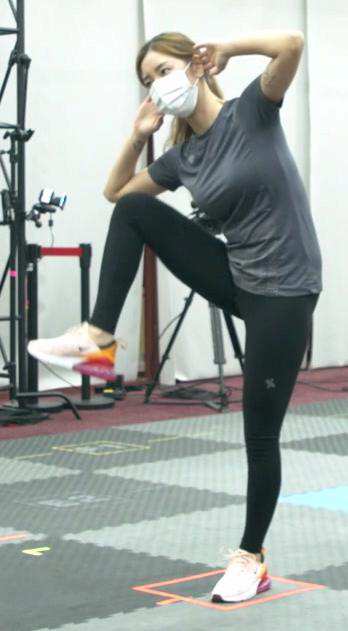

In [15]:
Image.open(train_imgs[100])

가로 이미지의 대표적인 예

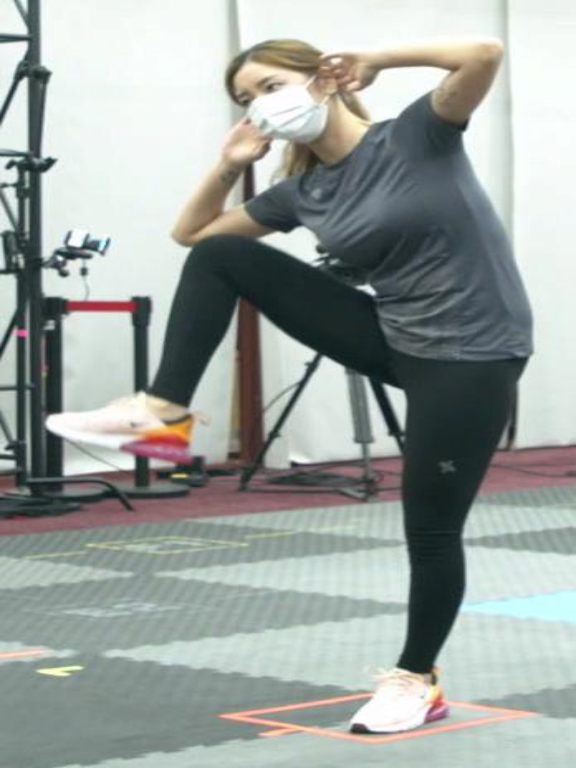

In [19]:
Image.fromarray(cv2.resize(imageio.imread(train_imgs[100]), (576, 768)))

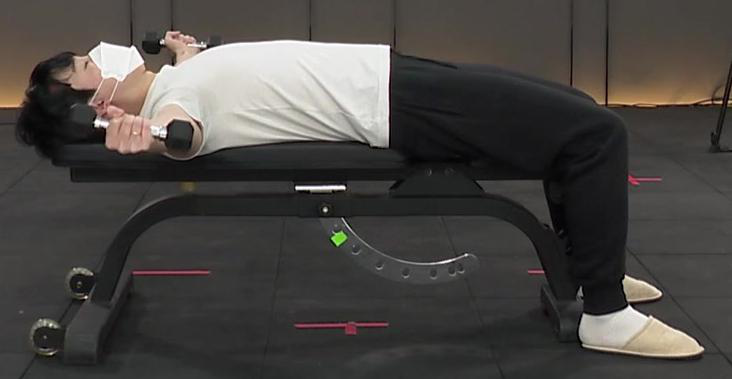

In [17]:
Image.open(train_imgs[4000])

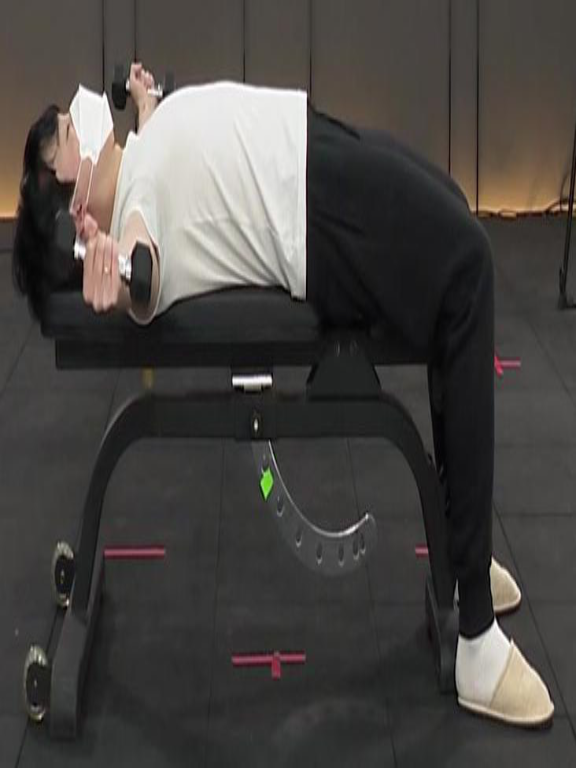

In [20]:
Image.fromarray(cv2.resize(imageio.imread(train_imgs[4000]), (576, 768)))

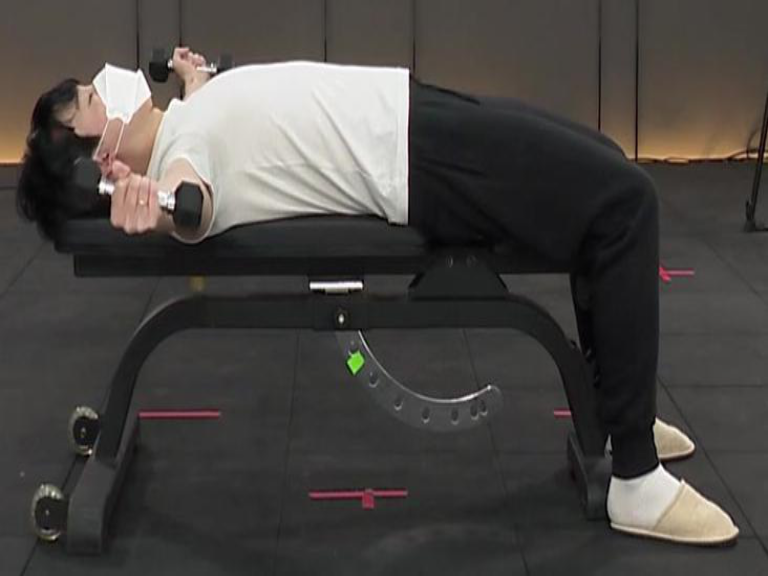

In [21]:
Image.fromarray(cv2.resize(imageio.imread(train_imgs[4000]), (768, 576)))

하지만 문제는 이미지 크기가 다르면 합쳐지지 않는다는 것

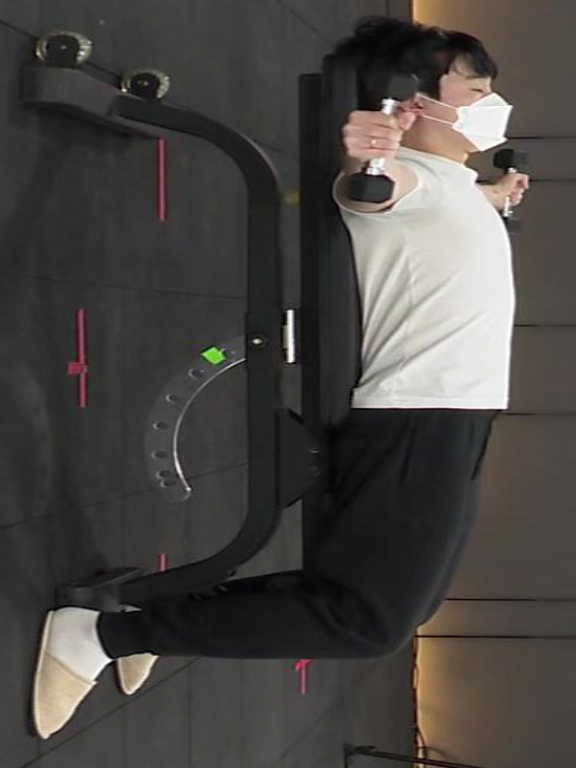

In [22]:
Image.fromarray(cv2.rotate(cv2.resize(imageio.imread(train_imgs[4000]), (768, 576)), cv2.ROTATE_90_CLOCKWISE))

이건 다음에 고려해보고, 지금은 그냥 전부 세로로 고정하자